In [134]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [135]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0, max=L[i])
    return x


In [136]:
N_Agents = 1
in_dim = 2
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 3
control_energy_reg = 1e-5#1e-6 ### regularization on maximum control energy
u_max = 1 # does not do anything currently
thres = 0#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [137]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    # = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    #return np.where((x > 0.6) & (x < 0.9),3, 0)
max_pdf = 5 / 3

In [138]:
from densities import uniform_rect_regions as pdf
import functools
#    region  = np.array([[[0, 1.], [0, 1.]],
#                        [[0.6, 0.9], [0.7, 0.9]]])
region  = np.array([[[0, 1.], [0, 1.]]])
custom_pdf = functools.partial(pdf, regions=region)

In [169]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = max_pdf, num_samples = 10000)


calulcated sigma: 0.10213474566340873


torch.Size([256, 3, 3])
model: tensor([[[4.1047e-01, 2.5656e-06, 6.3877e-22],
         [1.7585e-01, 7.6883e-04, 1.4566e-14],
         [8.1974e-05, 2.8442e-05, 9.8277e-16]],

        [[9.3374e-01, 4.3126e-05, 3.0809e-18],
         [3.4068e-05, 4.4191e-08, 4.5606e-21],
         [1.0315e-18, 2.4376e-21, 2.7246e-34]],

        [[3.8767e-01, 6.5305e-06, 3.6658e-16],
         [1.6424e-02, 8.4166e-02, 2.2098e-08],
         [3.5506e-08, 1.1718e-04, 1.0078e-10]],

        ...,

        [[1.4926e-01, 4.7246e-06, 1.2608e-16],
         [1.6805e-02, 7.7433e-02, 1.2497e-06],
         [7.8735e-08, 1.5933e-02, 3.9055e-05]],

        [[3.3775e-01, 2.1110e-06, 5.1539e-22],
         [2.0753e-01, 1.2012e-04, 1.3428e-15],
         [1.2453e-03, 2.7462e-04, 7.5781e-15]],

        [[8.5432e-01, 1.3988e-03, 1.4354e-14],
         [7.6730e-06, 4.4940e-07, 6.5223e-18],
         [2.4797e-20, 7.4718e-21, 1.2075e-31]]], grad_fn=<CopySlices>) target: tensor([[0.1261, 0.1867, 0.1245],
        [0.1755, 0.2574, 0.1835],

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Epoch [500/500], Loss: 0.669393, lr: 0.001000


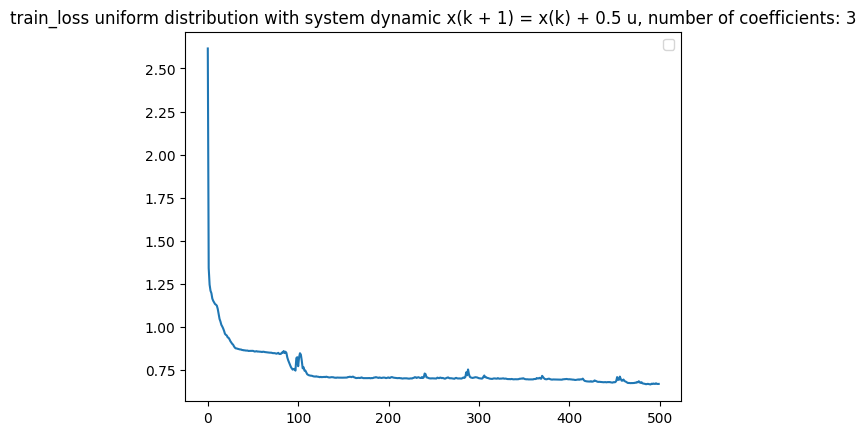

Training Complete!


In [170]:
############ Empircally we need loss < 0.01
import time
criterion.verbose = True
epochs = 500  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
decreased = False
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, eps = 1e-4)
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        outputs, control = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty # punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if show:
            show = False
            criterion.verbose = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)    
    avg_loss = running_loss / (n_samples // batch_size)
    ### He gets stuck here and often times not unstuck!
    #if avg_loss < 0.011 and not decreased:
    #    for param_group in optimizer.param_groups:
    #        param_group['lr'] *= 0.1
    #    decreased = True
    #if avg_loss < 0.009:
    #    break

    #scheduler.step(avg_loss) #### In our case test loss is the same as train loss
    print() 
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}, lr: {optimizer.param_groups[0]['lr']:6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u, number of coefficients: {criterion.k_compare}')
plt.legend()
plt.show()
print("Training Complete!")

In [171]:
criterion.verbose = True
inital_state = gen_sample(batch_size = 256, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 256)
outs, control = model(inital_state)
criterion(x = outs, u = control)

torch.Size([256, 3, 3])
model: tensor([[[9.5553e-04, 1.8095e-01, 1.2550e-06],
         [4.0203e-03, 2.6265e-01, 2.8070e-02],
         [4.0401e-06, 1.7785e-01, 5.5228e-04]],

        [[1.2289e-06, 1.8579e-01, 4.2894e-06],
         [2.5695e-06, 2.5213e-01, 4.9606e-02],
         [1.7202e-06, 1.8276e-01, 2.7231e-04]],

        [[1.2303e-06, 1.8692e-01, 1.3382e-06],
         [2.2624e-05, 2.5378e-01, 9.3291e-06],
         [6.4773e-03, 1.7113e-01, 4.7736e-02]],

        ...,

        [[1.2164e-06, 1.7917e-01, 8.2499e-04],
         [2.5484e-06, 2.4990e-01, 4.2471e-02],
         [1.6934e-06, 1.8113e-01, 2.6639e-05]],

        [[1.1568e-04, 1.9084e-01, 6.4823e-05],
         [2.8085e-06, 2.4846e-01, 4.3725e-02],
         [2.8220e-06, 1.7830e-01, 2.3364e-05]],

        [[1.3231e-06, 2.1887e-01, 2.0640e-03],
         [2.6508e-06, 2.5122e-01, 3.6502e-02],
         [2.3239e-06, 1.7594e-01, 3.5763e-06]]], grad_fn=<CopySlices>) target: tensor([[0.1261, 0.1867, 0.1245],
        [0.1755, 0.2574, 0.1835],

tensor(0.6671, grad_fn=<AddBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


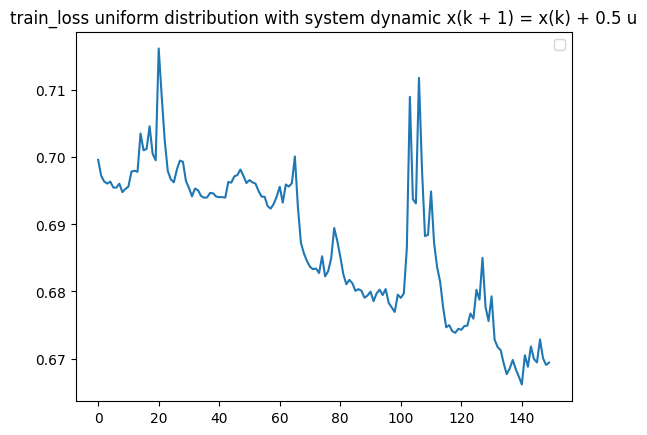

Training Complete!


In [172]:
plt.plot(train_loss[-150:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

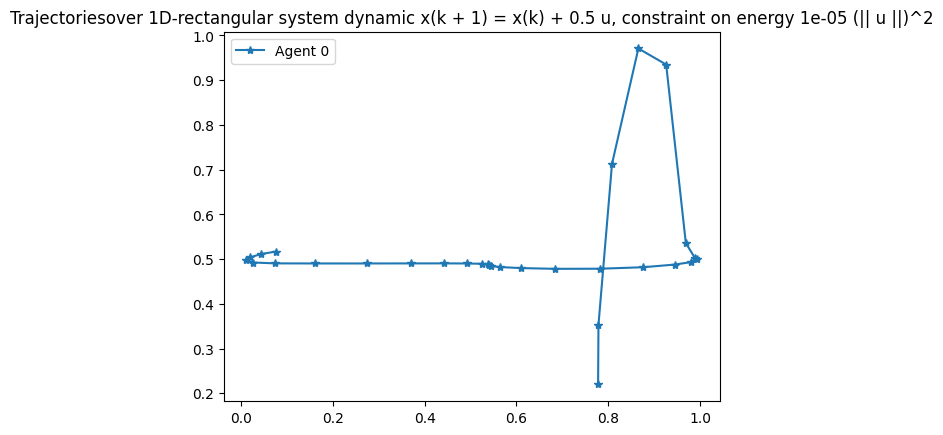

torch.Size([1, 3, 3])
model: tensor([[[1.2358e-06, 1.8885e-01, 1.3723e-06],
         [8.7326e-05, 2.5530e-01, 6.5935e-05],
         [3.1747e-04, 1.7834e-01, 3.4385e-02]]], grad_fn=<CopySlices>) target: tensor([[0.1261, 0.1867, 0.1245],
        [0.1755, 0.2574, 0.1835],
        [0.1270, 0.1803, 0.1295]])


tensor(0.6703, grad_fn=<AddBackward0>)

In [183]:
model.eval()
criterion.verbose = True
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    trajectory = outs[:,:,j,:].squeeze().detach()
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='*', linestyle='-', label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)



In [144]:
import uuid
import os
random_id = str(uuid.uuid4())[:8]
filename = f'model_uniform_region_Noise_0-0.3.0.6-0.9_multiple_Agents{random_id}.pth'
path = os.path.join('models' , filename)
torch.save(model.state_dict(), path)
print(f"Model saved with filename: {filename}")

Model saved with filename: model_uniform_region_Noise_0-0.3.0.6-0.9_multiple_Agents15cbed7f.pth


In [145]:
ev = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32 , depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
ev.load_state_dict(torch.load(path))

<All keys matched successfully>

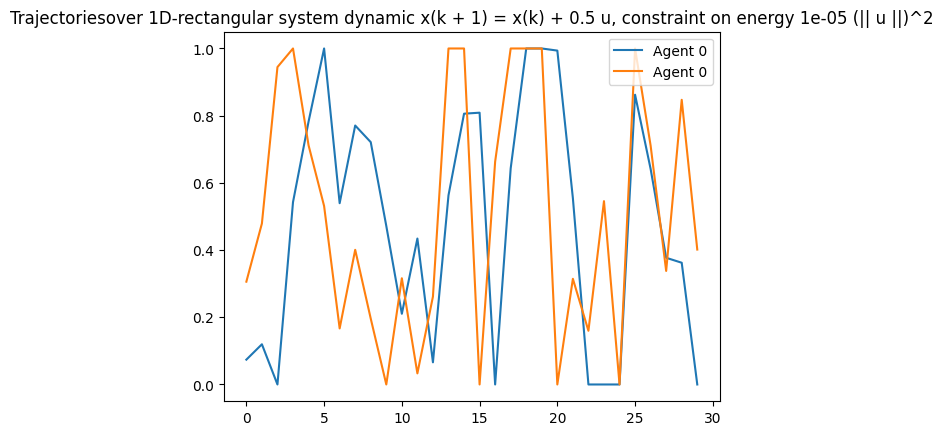

torch.Size([1, 3, 3])
model: tensor([[[0.0445, 0.0838, 0.0289],
         [0.0671, 0.0127, 0.0757],
         [0.0392, 0.0339, 0.0857]]], grad_fn=<CopySlices>) target: tensor([[0.1277, 0.1804, 0.1286],
        [0.1759, 0.2589, 0.1824],
        [0.1299, 0.1791, 0.1286]])


tensor(0.0599, grad_fn=<AddBackward0>)

In [146]:
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
ev.init_hidden(batch_size = 1)
outs, control = ev(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)